## Install Required Packages

# Practical and Consistent Estimation of $f$-Divergence

In [1]:
!pip install --upgrade pip
!pip install cvxpy
!pip install seaborn
!pip install --upgrade tensorflow-probability

## Import Required Libraries

In [1]:
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("Num GPUs Available: ", len(gpus))
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt
import numpy as np
import cvxpy as cp
import time
import os

import matplotlib.cm as cm
from scipy import stats
from scipy.special import logsumexp

import h5py

import seaborn as sns

from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif':['Helvetica']})
rc('text', usetex=False)

Tensorflow version: 2.4.1
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


- $\chi^2$-divergence:
    
    $\chi^2(P, Q) = \int \log \Bigl(p(z) / q(z)\Bigr)^2 q(z) dz - 1$.

## Closed-Form Divergence Computations

### Helper functions

In [3]:
def get_dims(A):
    """Gets input and latent dimensions from matrix (tensor) A.
    
    Input dimension: #columns.
    Latent dimension: #rows.
    
    Args:
        A: Parameter matrix.
    Returns:
        dim_latent, dim_input: A tuple containing lists representing the row and column
                                dimensions of the parameter matrix A.
    """
    dim_latent, dim_input = A.get_shape().as_list()
    
    return dim_latent, dim_input

def get_cov(A, std):
    """Constructs the covariance matrix with given matrix and standard deviation.
    
    Args:
        A: Parameter matrix determining the covariance matrix.
    Returns:
        cov: A tf tensor representing the constructed covariance matrix.
        
    """
    dim_latent, _ = get_dims(A)
    cov = tf.matmul(A, A, transpose_b=True) + std**2 * tf.eye(dim_latent)
    
    return cov

### Compute KL-divergence

KL-divergence:

   $D_{KL}(Q, P) = \int \log \Bigl(q(z) / p(z)\Bigr) q(z) dz$

In [4]:
def compute_kl(A, b, std):
    """Computes the KL-divergence between baseline distribution Pz and distribution Qz.
    
    Here the baseline distribution Pz is a unit Multivariate Normal distribution with
    mean zero and diag(1) covariance. The distribution Qz is a Multivariate Normal
    distribution with mean b and covariance AA^t + (std**2)I.
    
    Args:
        A: Parameter matrix determining covariance matrix of Qz.
        b: Mean of Qz.
        std: Standard deviation parameter determining covariance matrix of Qz.
    Returns:
        kl_divergence: A numpy array of computed KL-divergence.
    """
    dim_latent, _ = get_dims(A)
    # Create a Multivariate Normal distribution with a diagonal covariance and mean 0.
    # The Multivariate Normal distribution is defined over R^k and parameterized by a
    # length-k loc vector (aka 'mu') and a k xk scale matrix; Note that the covariance
    # is given by covariance = scale @ scale.T, where @ denotes matrix multiplication
    p = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dim_latent,)),
                                 scale_diag=tf.ones(dim_latent))
    q_cov = get_cov(A, std)
    q = tfd.MultivariateNormalTriL(loc=b, scale_tril=tf.linalg.cholesky(q_cov))
    kl_divergence = q.kl_divergence(p).numpy()
    
    return kl_divergence

### Compute Squared Hellinger distance

Squared Hellinger distance:

   $\mathcal{H}^2(P, Q) = \int \Bigl(\sqrt{p(z)} - \sqrt{q(z)}\Bigr)^2 dz$
   
 Squared Hellinger distance is a *metric* to measure the difference between two probability distributions. It is the probabilistic analog of **Euclidean Distance**.

In [5]:
def compute_h2(A, b, std):
    """Computes the squared Hellinger distance between unit Gaussian Pz and Gaussian Qz
    with mean b and covariance AA^t + (std**2)I.
    """
    dim_latent, dim_input = get_dims(A)
    Sigma1 = tf.eye(dim_latent)
    Sigma2 = tf.matmul(A, A, transpose_b=True) + std**2 * tf.eye(dim_latent)
    result = tf.linalg.logdet(Sigma1) / 4. + tf.linalg.logdet(Sigma2) / 4.
    result -= tf.linalg.logdet(0.5 * Sigma1 + 0.5 * Sigma2) / 2.
    result = tf.exp(result)
    quad_form = tf.matmul(tf.linalg.inv(0.5 * Sigma1 + 0.5 * Sigma2),
                         tf.reshape(b, (dim_latent, -1)))
    quad_form = tf.matmul(tf.reshape(b, (-1, dim_latent)), quad_form)
    result *= tf.exp(-1. / 8 * quad_form)
    
    return (2. - 2. * result[0, 0]).numpy()

## Estimators

In [6]:
def compute_ram_mc(n, m, A, b, std, f, num_iters):
    """Estimates Df(Qz, Pz) with RAM-MC estimator where Pz is a unit Gaussian and Qz
    is a Gaussian with mean b and covariance AA^t + (std**2)I.
    
    Args:
        n: Number of mixture components to approximate Qz.
        m: Number of MC samples to use.
        A: Parameter determining covariance matrix of Qz.
        b: Mean of Qz.
        std: Standard deviation parameter determining covariance matrix of Qz.
        f: A string representing the f-divergence type, now "KL" only.
        num_iters: Number of iterations to perform.
    Returns:
        estimates: A numpy array of estimates, one per num_iter.
    """
    dim_latent, dim_input = get_dims(A)
    p = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dim_latent,)),
                                 scale_diag=tf.ones(dim_latent))
    # Base P(X) distribution, which is a standard normal in d_input.
    p_base = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dim_input,)),
                                 scale_diag=tf.ones(dim_input))
    
    p_base_samples = p_base.sample(n * num_iters) # Minibatch samples from P(X).
    p_base_samples = tf.reshape(p_base_samples, [num_iters, n, dim_input])
    A = tf.reshape(A, [1, dim_latent, dim_input])
    # Create a new tensor by replicating A num_iters times.
    A = tf.tile(A, [num_iters, 1, 1])
    p_base_posterior = tfd.MultivariateNormalDiag(
        loc=tf.matmul(p_base_samples, A, transpose_b=True) + b,
        scale_diag=std * tf.ones(dim_latent)
    )
    # Compute a mixture distribution. Experiment-specific parameters are indexed with
    # the first dimension (num_iters) in p_base_posterior.
    mixture = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1. / n] * n),
        components_distribution=p_base_posterior
    )
    if f == 'KL':
        mc_samples = mixture.sample(m)
        log_density_ratios = mixture.log_prob(mc_samples) - p.log_prob(mc_samples)
        estimates = (tf.reduce_mean(log_density_ratios, axis=0)).numpy()
    elif f == 'H2':
        mc_samples = mixture.sample(m)
        logratio = -mixture.log_prob(mc_samples) + p.log_prob(mc_samples)
        estimates = 2.
        estimates -= 2. * tf.exp(tf.reduce_logsumexp(0.5 * logratio, axis=0)) / m
        estimates = estimates.numpy()
    else:
        raise ValueError("f must be one of 'KL', 'H2'.")
    
    return estimates

## Plug-in Estimator

In [7]:
def estimator_plugin(n, m, A, b, std, f, num_iters, eps=1e-8):
    """Estimates Df(Qz, Pz) with the plugin estimator. Pz is the unit Gaussian and Qz is
    Gaussian with mean b and covariance AA^t +(std**2)I. First perform kernel density
    estimation of two densities, then plug in.
    """
    def numpy_sample(p, n, d):
        points = p.sample(n)
        points = tf.reshape(points, [d, -1]).numpy()
        
        return points
    
    dim_latent, dim_input = get_dims(A)
    p = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dim_latent,)),
                                   scale_diag=tf.ones(dim_latent))
    q_cov = get_cov(A, std)
    q = tfd.MultivariateNormalTriL(loc=b, scale_tril=tf.linalg.cholesky(q_cov))

    
    # Repeat experiments for num_iters iterations.
    results = []
    for experiment in range(num_iters):
        # Get i.i.d. samples from p and q to perform kernel density estimations.
        p_kde_points = numpy_sample(p, n, dim_latent)
        q_kde_points = numpy_sample(q, n, dim_latent)
    
        try:
            p_hat = stats.gaussian_kde(p_kde_points)
            q_hat = stats.gaussian_kde(q_kde_points)
        except:
            results.append(np.nan)
            continue

        mc_points = numpy_sample(q, m, dim_latent)
        try:
            q_vals = q_hat.evaluate(mc_points)
            p_vals = p_hat.evaluate(mc_points) + eps
            log_q_vals = q_hat.logpdf(mc_points)
            log_p_vals = p_hat.logpdf(mc_points) + eps
        except:
            results.append(np.nan)
            continue

        if f == 'KL':
            results.append(np.mean(log_q_vals - log_p_vals))
        elif f  == 'H2':
            logratio = log_p_vals - log_q_vals
            estimate_val = 2.
            estimate_val -= 2. * np.exp(logsumexp(0.5 * logratio)) / m
            results.append(estimate_val)
        else:
            raise ValueError("f must be one of 'KL', 'H2'.")
            
    return np.array(results)

## Run experiments and make plots

### Experiment configurations

In [8]:
N_RANGE = [1, 500] # Sample sizes
MC_NUM = 128 # Number of Monte-Carlo samples for RAM-MC
N_EXP = 10 # Number of iterations to repeat each experiment
K = 20 # Base space dimensionality.
STD = 0.5 # Gaussian covariance noise.
BETA = 0.5 # Scale for base covariance.
D_RANGE = [1, 4, 16] # Latent space dimensionality.
LBD_MAX = 2. # Lambda range.
ROOT_PATH = '/data/'

tf.random.set_seed(345)

# Generating A and b parameters for various dimensions.
BASE_PARAMS = {}
for d in D_RANGE:
    b0 = tf.random.normal(shape=(d,))
    b0 /= np.linalg.norm(b0)
    A0 = tf.random.normal(shape=(d, K))
    A0 /= tf.linalg.norm(A0)
    BASE_PARAMS[d] = {'b0': b0, 'A0': A0}

### Run experiments

In [9]:
RUN_RAM_MC_PLUGIN_EXPERIMENTS = True

def load_figure1_data(file_name):
    data = {}
    path = os.path.join(ROOT_PATH, file_name)
    with h5py.File(path, 'r') as f:
        for i in f:
            data[int(i)] = {}
            for j in f[i]:
                data[int(i)][int(j)] = {}
                for k in f[i][j]:
                    data[int(i)][int(j)][k] = list(f[i][j][k])
    return data

if RUN_RAM_MC_PLUGIN_EXPERIMENTS:
    ram_mc_plugin_results = {}
    for d in D_RANGE:
        if d not in ram_mc_plugin_results:
            ram_mc_plugin_results[d] = {}
        for n in N_RANGE:
            print(d, n)
            if n not in ram_mc_plugin_results[d]:
                ram_mc_plugin_results[d][n] = {}
            for lbd in np.linspace(-LBD_MAX, LBD_MAX, 51):
                # Create Abase with ones on diagonal
                Abase = np.zeros((d, K))
                np.fill_diagonal(Abase, 1.)
                Abase = tf.convert_to_tensor(Abase, tf.dtypes.float32)
                Albd = Abase * BETA + lbd * BASE_PARAMS[d]['A0']
                blbd = lbd * BASE_PARAMS[d]['b0']

                # Compute true closed form values (only once)
                if n == N_RANGE[0]:
                    true_kl = compute_kl(Albd, blbd, STD)
                    true_h2 = compute_h2(Albd, blbd, STD)
                else:
                    true_kl = None
                    true_h2 = None

                for dvg in ['KL', 'H2']:
                    if dvg not in ram_mc_plugin_results[d][n]:
                        ram_mc_plugin_results[d][n][dvg] = []
                        
                    batch_ram_mc = compute_ram_mc(n, MC_NUM, Albd, blbd, STD,
                                                  f=dvg, num_iters=N_EXP)
                        
                    batch_plugin = estimator_plugin(n, MC_NUM, Albd, blbd, STD,
                                                   f=dvg, num_iters=N_EXP)
                    
                    ram_mc_plugin_results[d][n][dvg].append(
                        (true_kl, true_h2, batch_ram_mc, batch_plugin))
else:
    ram_mc_plugin_results = load_figure1_data('ram_mc_plugin_results.hdf5')

1 1
1 500
4 1


/usr/local/lib/python3.6/dist-packages/scipy/stats/kde.py:567: RuntimeWarning: Degrees of freedom <= 0 for slice
  aweights=self.weights))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


4 500
16 1
16 500


In [10]:
ram_mc_plugin_results[1][1]['H2'][0][3]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

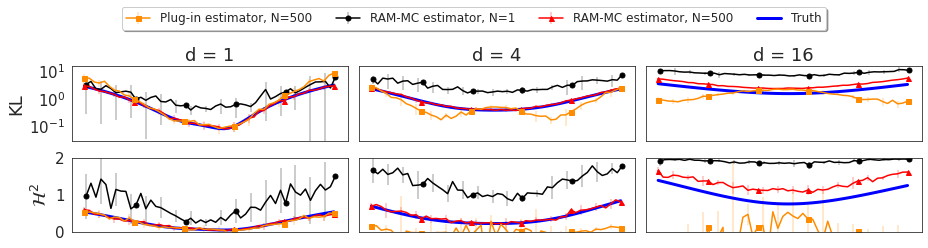

In [11]:
def make_plot_figure1(ram_mc_plugin_results):
    sns.set_style("white")
    fig = plt.figure(figsize = (13, 3))
    elinewidth = 0.4  # Width of errorbars
    errorevery = 3  # Set spacing of error bars to avoid crowding of figure.
    
    def overflow_std(array):
        """Calculates std of array, but if overflow error would occur returns a 
        finite number larger than the range of any axes used in plots."""
        if (np.inf in array) or (np.nan in array) or any(1e20 < array):
            std = 1e20
        else:
            std = np.std(array)
        
        return std
    
    for i in range(1, 7):
        sp = plt.subplot(2, 3, i)
        d = D_RANGE[(i - 1) % 3]
        dvg = ['KL', 'H2'][int((i - 1) / 3)]
        colors = cm.rainbow(np.linspace(0, 1, len(N_RANGE)))
        
        for color, n in zip(colors, N_RANGE):
            if n == N_RANGE[0]:
                # Plot true values
                idx = N_RANGE[0]
                true_kl = np.array([el[0] for el in ram_mc_plugin_results[d][idx][dvg]])
                true_h2 = np.array([el[1] for el in ram_mc_plugin_results[d][idx][dvg]])
                
                if dvg == 'KL':
                    plt.plot(true_kl, color='blue', linewidth=3, label='Truth')
                    plt.yscale('log')
                if dvg == 'H2':
                    plt.plot(true_h2, color='blue', linewidth=3, label='Truth')
                    
            # Plot RAM-MC estimates for N=500.
            if n == 500:
                mean_ram_mc_n500 = np.array(
                    [np.mean(el[2]) for el in ram_mc_plugin_results[d][n][dvg]])
                std_ram_mc_n500 = np.array(
                    [np.std(el[2]) for el in ram_mc_plugin_results[d][n][dvg]])
                color = 'red'
                plt.errorbar(range(51),
                             mean_ram_mc_n500,
                             errorevery=errorevery,
                             yerr=std_ram_mc_n500,
                             elinewidth=elinewidth,
                             color=color, label='RAM-MC estimator, N=' + str(n),
                             marker="^", markersize=5, markevery=10)
            
            # Plot plug-in estimates
            if n == 500:
                mean_plugin = np.array(
                    [np.mean(el[3]) for el in ram_mc_plugin_results[d][n][dvg]])
                std_plugin = np.array(
                    [overflow_std(el[3]) for el in ram_mc_plugin_results[d][n][dvg]])
                color = 'darkorange'
                plt.errorbar(range(51),
                             mean_plugin,
                             errorevery=errorevery,
                             yerr=std_plugin,
                             elinewidth=elinewidth,
                             color=color, label='Plug-in estimator, N=' + str(n),
                             marker="s", markersize=5, markevery=10)
            
            # Plot RAM-MC with N=1.
            if n == N_RANGE[0]:
                color = 'black'
                mean_ram_mc1 = np.array(
                    [np.mean(el[2]) for el in ram_mc_plugin_results[d][n][dvg]])
                std_ram_mc1 = np.array(
                    [np.std(el[2]) for el in ram_mc_plugin_results[d][n][dvg]])
                plt.errorbar(range(51) + 0.3 * np.ones(51),
                             mean_ram_mc1,
                             errorevery=errorevery,
                             yerr=std_ram_mc1,
                             elinewidth=elinewidth,
                             color=color, label='RAM-MC estimator, N=1',
                             marker="o", markersize=5, markevery=10)
                
            if dvg == 'KL':
                plt.ylim((0.03, 15))
            if dvg == 'H2':
                plt.ylim((0., 2))
            
        sp.axes.get_xaxis().set_ticklabels([])
        if d != 1:
            sp.axes.get_yaxis().set_ticklabels([])
        else:
            sp.axes.tick_params(axis='both', labelsize=15)
        
        if i < 4:
            plt.title("d = {}".format(d), fontsize=18)
        if i == 1:
            plt.ylabel('KL', fontsize=18)
        if i == 4:
            plt.ylabel(r'$\mathcal{H}^2$', fontsize=18)

    ax = fig.axes[1]
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.51, 1.0),
               ncol=5, fancybox=True, shadow=True, fontsize=12, frameon=True)
    plt.tight_layout()
    plt.show()

make_plot_figure1(ram_mc_plugin_results)